TOTAL EV = $219,819.56


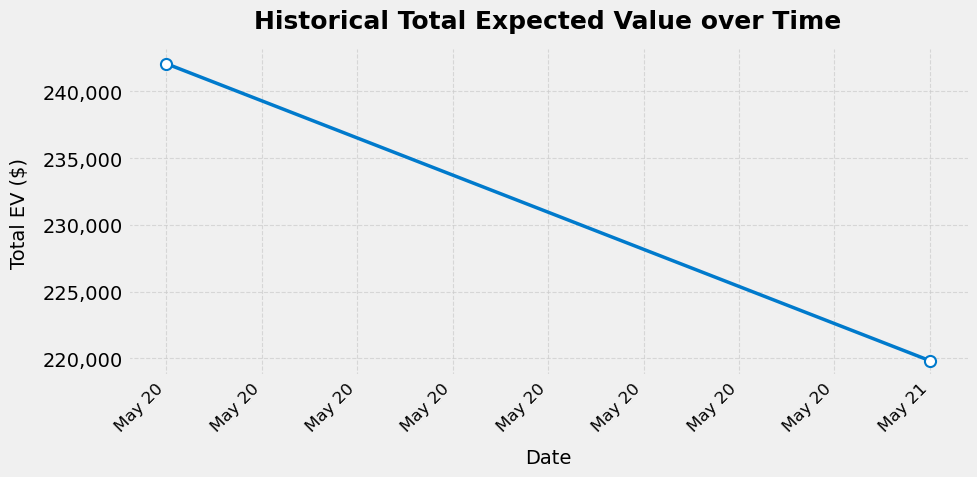

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Imports & config
# ─────────────────────────────────────────────────────────────────────────────
import re
from collections import defaultdict
from datetime import datetime, date

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from urllib.parse import quote_plus
import pymysql
import sqlalchemy

# ─────────────────────────────────────────────────────────────────────────────
# 2) Database credentials
# ─────────────────────────────────────────────────────────────────────────────
BET_HOST    = "betting-db.cp86ssaw6cm7.us-east-1.rds.amazonaws.com"
BET_USER    = "admin"
BET_PW      = "7nRB1i2&A-K>"
BET_DB      = "betting_db"

FUT_HOST    = "greenalephfutures.cnwukek8ge3b.us-east-2.rds.amazonaws.com"
FUT_USER    = "admin"
FUT_PW      = "greenalephadmin"
FUT_DB      = "futuresdata"

bet_pw_escaped = quote_plus(BET_PW)
engine_bet = sqlalchemy.create_engine(
    f"mysql+pymysql://{BET_USER}:{bet_pw_escaped}@{BET_HOST}/{BET_DB}"
)
fut_pw_escaped = quote_plus(FUT_PW)
engine_fut = sqlalchemy.create_engine(
    f"mysql+pymysql://{FUT_USER}:{fut_pw_escaped}@{FUT_HOST}/{FUT_DB}"
)

# ─────────────────────────────────────────────────────────────────────────────
# 3) Odds-conversion & mapping helpers
# ─────────────────────────────────────────────────────────────────────────────
def american_odds_to_decimal(o: int) -> float:
    if o > 0:   return 1.0 + o/100.0
    if o < 0:   return 1.0 + 100.0/abs(o)
    return 1.0

def american_odds_to_prob(o: int) -> float:
    if o > 0:   return 100.0/(o + 100.0)
    if o < 0:   return abs(o)/(abs(o) + 100.0)
    return 0.0

def cast_odds(v) -> int:
    if v in (None, "", 0): return 0
    if isinstance(v, (int, float)): return int(v)
    m = re.search(r"[-+]?\d+", str(v))
    return int(m.group()) if m else 0

futures_table_map = {
    ("Championship","NBA Championship"): "NBAChampionship",
    ("Conference Winner","Eastern Conference"): "NBAEasternConference",
    ("Conference Winner","Western Conference"): "NBAWesternConference",
    ("Defensive Player of Year Award","Award"): "NBADefensivePotY",
    ("Division Winner","Atlantic Division"): "NBAAtlantic",
    ("Division Winner","Central Division"):  "NBACentral",
    ("Division Winner","Northwest Division"): "NBANorthwest",
    ("Division Winner","Pacific Division"):  "NBAPacific",
    ("Division Winner","Southeast Division"): "NBASoutheast",
    ("Division Winner","Southwest Division"): "NBASouthwest",
    ("Most Improved Player Award","Award"):  "NBAMIP",
    ("Most Valuable Player Award","Award"):  "NBAMVP",
    ("Rookie of Year Award","Award"):        "NBARotY",
    ("Sixth Man of Year Award","Award"):     "NBASixthMotY",
}
team_alias_map = {
    "Philadelphia 76ers":"76ers","Milwaukee Bucks":"Bucks","Chicago Bulls":"Bulls",
    "Cleveland Cavaliers":"Cavaliers","Boston Celtics":"Celtics","Los Angeles Clippers":"Clippers",
    "Memphis Grizzlies":"Grizzlies","Atlanta Hawks":"Hawks","Miami Heat":"Heat",
    "Charlotte Hornets":"Hornets","Utah Jazz":"Jazz","Sacramento Kings":"Kings",
    "New York Knicks":"Knicks","Los Angeles Lakers":"Lakers","Orlando Magic":"Magic",
    "Dallas Mavericks":"Mavericks","Brooklyn Nets":"Nets","Denver Nuggets":"Nuggets",
    "Indiana Pacers":"Pacers","New Orleans Pelicans":"Pelicans","Detroit Pistons":"Pistons",
    "Toronto Raptors":"Raptors","Houston Rockets":"Rockets","San Antonio Spurs":"Spurs",
    "Phoenix Suns":"Suns","Oklahoma City Thunder":"Thunder","Minnesota Timberwolves":"Timberwolves",
    "Portland Trail Blazers":"Trail Blazers","Golden State Warriors":"Warriors","Washington Wizards":"Wizards",
}
sportsbook_cols = ["BetMGM","DraftKings","Caesars","ESPNBet","FanDuel","BallyBet","RiversCasino","Bet365"]

def best_odds_decimal_prob(event_type, event_label, participant, cutoff_dt, vig_map):
    tbl = futures_table_map.get((event_type, event_label))
    if tbl is None:
        return 1.0, 0.0

    alias = team_alias_map.get(participant, participant)
    target_date = cutoff_dt.date()

    with engine_fut.connect() as conn:
        rows = conn.execute(
            sqlalchemy.text(f"""
                SELECT {','.join(sportsbook_cols)}, DATE(date_created) as dt
                  FROM {tbl}
                 WHERE team_name = :alias
                   AND DATE(date_created) = :target_date
              ORDER BY date_created DESC
                 LIMIT 100
            """), {"alias": alias, "target_date": target_date}
        ).mappings().all()

    for r in rows:
        quotes = [cast_odds(r[c]) for c in sportsbook_cols]
        valid_quotes = [q for q in quotes if q]

        if not valid_quotes:
            continue  # All zero or None; try next row (same day, newer timestamp)

        best = max(valid_quotes, key=american_odds_to_prob)
        dec = american_odds_to_decimal(best)
        prob = american_odds_to_prob(best) * (1 - vig_map.get((event_type, event_label), 0.05))
        return dec, prob

    # No valid odds found on that date
    return 1.0, 0.0



# ─────────────────────────────────────────────────────────────────────────────
# 4) Build full EV table
# ─────────────────────────────────────────────────────────────────────────────
def build_ev_table():
    now    = datetime.utcnow()
    vig    = {k: 0.05 for k in futures_table_map}
    active_stake, active_exp = defaultdict(float), defaultdict(float)
    realized_np = defaultdict(float)

    # Active NBA futures
    df_active = pd.read_sql("""
        SELECT b.WagerID, b.PotentialPayout, b.DollarsAtStake,
               l.EventType, l.EventLabel, l.ParticipantName
          FROM bets b JOIN legs l ON b.WagerID = l.WagerID
         WHERE b.WhichBankroll = 'GreenAleph'
           AND b.WLCA = 'Active'
           AND l.LeagueName = 'NBA'
    """, engine_bet)

    gb = df_active.groupby("WagerID", as_index=False)
    bets = {}
    for wid, grp in gb:
        bets[wid] = {
            "pot":   float(grp.PotentialPayout.iloc[0] or 0),
            "stake": float(grp.DollarsAtStake.iloc[0] or 0),
            "legs":  list(grp[["EventType","EventLabel","ParticipantName"]]\
                         .itertuples(index=False, name=None))
        }

    for b in bets.values():
        decs, prob = [], 1.0
        for et, el, pn in b["legs"]:
            dec, p = best_odds_decimal_prob(et, el, pn, now, vig)
            if p == 0:
                prob = 0
                break
            decs.append(dec)
            prob *= p
        if prob == 0:
            continue
        expected = b["pot"] * prob
        exc_sum  = sum(d - 1 for d in decs)
        if exc_sum <= 0:
            continue
        for d in decs:
            w = (d - 1) / exc_sum
            active_stake[(et, el)] += w * b["stake"]
            active_exp  [(et, el)] += w * expected

    # Realized NBA futures
    df_real = pd.read_sql("""
        SELECT b.WagerID, b.NetProfit,
               l.EventType, l.EventLabel, l.ParticipantName
          FROM bets b JOIN legs l ON b.WagerID = l.WagerID
         WHERE b.WhichBankroll = 'GreenAleph'
           AND b.WLCA IN ('Win','Loss','Cashout')
           AND l.LeagueName = 'NBA'
    """, engine_bet)

    net = df_real.groupby("WagerID").NetProfit.first().to_dict()
    legs_map = df_real.groupby("WagerID")[["EventType","EventLabel","ParticipantName"]]\
                      .apply(lambda df: list(df.itertuples(index=False, name=None)))\
                      .to_dict()

    for wid, legs in legs_map.items():
        npv    = float(net.get(wid, 0))
        decs   = [best_odds_decimal_prob(et, el, pn, now, vig)[0] for et, el, pn in legs]
        exc_sum = sum(d - 1 for d in decs)
        if exc_sum <= 0:
            continue
        for d, (et, el, _) in zip(decs, legs):
            realized_np[(et, el)] += npv * ((d - 1) / exc_sum)

    # Other sports
    df_other = pd.read_sql("""
        SELECT b.NetProfit, l.LeagueName, l.EventType, l.EventLabel
          FROM bets b JOIN legs l ON b.WagerID = l.WagerID
         WHERE b.WhichBankroll = 'GreenAleph'
           AND b.WLCA IN ('Win','Loss','Cashout')
           AND l.LeagueName <> 'NBA'
    """, engine_bet)

    other = df_other.groupby(["LeagueName","EventType","EventLabel"])\
                    .NetProfit.sum().to_dict()

    # Assemble rows + TOTAL
    rec = []
    for (et, el), tbl in futures_table_map.items():
        stk = active_stake.get((et, el), 0)
        exp = active_exp.get((et, el), 0)
        npv = realized_np.get((et, el), 0)
        rec.append({
            "LeagueName":"NBA", "EventType":et, "EventLabel":el,
            "ActiveDollarsAtStake": round(stk,2),
            "ActiveExpectedPayout": round(exp,2),
            "RealizedNetProfit": round(npv,2),
            "ExpectedValue": round(exp - stk + npv,2)
        })
    for (lg, et, el), npv in other.items():
        rec.append({
            "LeagueName":lg, "EventType":et, "EventLabel":el,
            "ActiveDollarsAtStake": 0.0,
            "ActiveExpectedPayout": 0.0,
            "RealizedNetProfit": round(npv,2),
            "ExpectedValue": round(npv,2)
        })

    df = pd.DataFrame(rec)
    df = df.sort_values(["LeagueName","EventType","EventLabel"]).reset_index(drop=True)

    total_net = float(pd.read_sql(
        "SELECT SUM(NetProfit) AS s FROM bets WHERE WhichBankroll='GreenAleph'",
        engine_bet
    ).iloc[0,0] or 0)
    total_row = {
        "LeagueName":"TOTAL","EventType":"", "EventLabel":"",
        "ActiveDollarsAtStake":     df.ActiveDollarsAtStake.sum(),
        "ActiveExpectedPayout":     df.ActiveExpectedPayout.sum(),
        "RealizedNetProfit":        round(total_net,2),
        "ExpectedValue":            round(df.ActiveExpectedPayout.sum()
                                       - df.ActiveDollarsAtStake.sum()
                                       + total_net,2)
    }
    df = pd.concat([df, pd.DataFrame([total_row])], ignore_index=True)
    return df

# ─────────────────────────────────────────────────────────────────────────────
# 5) Build, snapshot, load history & plot (with commas on y-axis)
# ─────────────────────────────────────────────────────────────────────────────
ev_df = build_ev_table()

today_ev = float(ev_df.loc[ev_df.LeagueName=="TOTAL", "ExpectedValue"].iloc[0])
print(f"TOTAL EV = ${today_ev:,.2f}")

with engine_bet.begin() as conn:
    conn.execute(
        sqlalchemy.text("""
            REPLACE INTO ev_history (snapshot_date, expected_value)
            VALUES (:d, :ev)
        """), {"d": date.today(), "ev": today_ev}
    )

hist = pd.read_sql("""
    SELECT snapshot_date AS date, expected_value AS ev
      FROM ev_history
     ORDER BY snapshot_date
""", engine_bet, parse_dates=["date"])

# ---- Improved plotting ----
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    hist.date,
    hist.ev,
    marker='o',
    markersize=8,
    markerfacecolor='white',
    markeredgewidth=1.5,
    markeredgecolor='#007ACC',
    linewidth=2.5,
    color='#007ACC',
)

ax.set_title(
    "Historical Total Expected Value over Time",
    fontsize=18, fontweight='bold', pad=15
)
ax.set_xlabel("Date", fontsize=14, labelpad=10)
ax.set_ylabel("Total EV ($)", fontsize=14, labelpad=10)

# X-axis: only dates, no times
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Y-axis: commas for thousands
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

ax.grid(which='major', linestyle='--', linewidth=0.8, alpha=0.7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


In [4]:
# ─────────────────────  NBA Futures EV Table (Jupyter)  ─────────────────────
import pandas as pd, re
from collections import defaultdict
from datetime import datetime
from typing import Dict, Tuple
from IPython.display import display

try:
    import pymysql
except ImportError as e:
    raise ImportError("PyMySQL is not installed. Run:  pip install pymysql") from e


# ─────────────────────  DB HELPERS  ─────────────────────
def new_betting_conn():
    return pymysql.connect(
        host="betting-db.cp86ssaw6cm7.us-east-1.rds.amazonaws.com",
        user="admin",
        password="7nRB1i2&A-K>",
        database="betting_db",
        cursorclass=pymysql.cursors.DictCursor,
        autocommit=True,
        connect_timeout=10,
    )


def new_futures_conn():
    return pymysql.connect(
        host="greenalephfutures.cnwukek8ge3b.us-east-2.rds.amazonaws.com",
        user="admin",
        password="greenalephadmin",
        database="futuresdata",
        cursorclass=pymysql.cursors.DictCursor,
        autocommit=True,
        connect_timeout=10,
    )


def with_cursor(conn):
    conn.ping(reconnect=True)
    return conn.cursor()


# ─────────────────────  ODDS HELPERS  ─────────────────────
def american_odds_to_decimal(o): return 1 + (o/100) if o > 0 else 1 + 100/abs(o) if o else 1
def american_odds_to_prob(o):    return 100/(o+100) if o > 0 else abs(o)/(abs(o)+100) if o else 0
def cast_odds(v):
    if v in (None, "", 0): return 0
    if isinstance(v, (int, float)): return int(v)
    m = re.search(r"[-+]?\d+", str(v))
    return int(m.group()) if m else 0


# ─────────────────────  MAPS & CONSTANTS  ─────────────────────
futures_table_map: Dict[Tuple[str, str], str] = {
    ("Championship", "NBA Championship"): "NBAChampionship",
    ("Conference Winner", "Eastern Conference"): "NBAEasternConference",
    ("Conference Winner", "Western Conference"): "NBAWesternConference",
    ("Defensive Player of Year Award", "Award"): "NBADefensivePotY",
    ("Division Winner", "Atlantic Division"): "NBAAtlantic",
    ("Division Winner", "Central Division"): "NBACentral",
    ("Division Winner", "Northwest Division"): "NBANorthwest",
    ("Division Winner", "Pacific Division"): "NBAPacific",
    ("Division Winner", "Southeast Division"): "NBASoutheast",
    ("Division Winner", "Southwest Division"): "NBASouthwest",
    ("Most Improved Player Award", "Award"): "NBAMIP",
    ("Most Valuable Player Award", "Award"): "NBAMVP",
    ("Rookie of Year Award", "Award"): "NBARotY",
    ("Sixth Man of Year Award", "Award"): "NBASixthMotY",
}

team_alias_map: Dict[str, str] = {
    "Philadelphia 76ers":"76ers","Milwaukee Bucks":"Bucks","Chicago Bulls":"Bulls",
    "Cleveland Cavaliers":"Cavaliers","Boston Celtics":"Celtics","Los Angeles Clippers":"Clippers",
    "Memphis Grizzlies":"Grizzlies","Atlanta Hawks":"Hawks","Miami Heat":"Heat",
    "Charlotte Hornets":"Hornets","Utah Jazz":"Jazz","Sacramento Kings":"Kings",
    "New York Knicks":"Knicks","Los Angeles Lakers":"Lakers","Orlando Magic":"Magic",
    "Dallas Mavericks":"Mavericks","Brooklyn Nets":"Nets","Denver Nuggets":"Nuggets",
    "Indiana Pacers":"Pacers","New Orleans Pelicans":"Pelicans","Detroit Pistons":"Pistons",
    "Toronto Raptors":"Raptors","Houston Rockets":"Rockets","San Antonio Spurs":"Spurs",
    "Phoenix Suns":"Suns","Oklahoma City Thunder":"Thunder","Minnesota Timberwolves":"Timberwolves",
    "Portland Trail Blazers":"Trail Blazers","Golden State Warriors":"Warriors","Washington Wizards":"Wizards",
}

sportsbook_cols = [
    "BetMGM","DraftKings","Caesars","ESPNBet","FanDuel",
    "BallyBet","RiversCasino","Bet365",
]


# ─────────────────────  BEST‑ODDS  ─────────────────────
def best_odds_decimal_prob(event_type, event_label, participant, cutoff_dt, vig_map):
    tbl = futures_table_map.get((event_type, event_label))
    if tbl is None:
        return 1.0, 0.0

    alias = team_alias_map.get(participant, participant)
    target_date = cutoff_dt.date()

    with engine_fut.connect() as conn:
        rows = conn.execute(
            sqlalchemy.text(f"""
                SELECT {','.join(sportsbook_cols)}, DATE(date_created) as dt
                  FROM {tbl}
                 WHERE team_name = :alias
                   AND DATE(date_created) = :target_date
              ORDER BY date_created DESC
                 LIMIT 100
            """), {"alias": alias, "target_date": target_date}
        ).mappings().all()

    for r in rows:
        quotes = [cast_odds(r[c]) for c in sportsbook_cols]
        valid_quotes = [q for q in quotes if q]

        if not valid_quotes:
            continue  # All zero or None; try next row (same day, newer timestamp)

        best = max(valid_quotes, key=american_odds_to_prob)
        dec = american_odds_to_decimal(best)
        prob = american_odds_to_prob(best) * (1 - vig_map.get((event_type, event_label), 0.05))
        return dec, prob

    # No valid odds found on that date
    return 1.0, 0.0




# ─────────────────────  MAIN LOGIC  ─────────────────────
def build_ev_table():
    bet_conn, fut_conn = new_betting_conn(), new_futures_conn()
    now = datetime.utcnow()
    vig = {k:0.05 for k in futures_table_map}

    cur = with_cursor(bet_conn)

    # ---------- ACTIVE NBA FUTURES ----------
    cur.execute("""
        SELECT b.WagerID, b.PotentialPayout, b.DollarsAtStake,
               l.EventType, l.EventLabel, l.ParticipantName
          FROM bets b JOIN legs l ON b.WagerID=l.WagerID
         WHERE b.WhichBankroll='GreenAleph'
           AND b.WLCA='Active'
           AND l.LeagueName='NBA'""")
    rows = cur.fetchall()

    active, act_stake, act_exp = defaultdict(lambda:{"pot":0,"stake":0,"legs":[]}), defaultdict(float), defaultdict(float)
    for r in rows:
        w = active[r["WagerID"]]
        w["pot"], w["stake"] = w["pot"] or float(r["PotentialPayout"] or 0), w["stake"] or float(r["DollarsAtStake"] or 0)
        w["legs"].append((r["EventType"], r["EventLabel"], r["ParticipantName"]))

    for data in active.values():
        pot, stake, legs = data.values()
        decs, prob = [], 1.0
        for et,el,pn in legs:
            dec, p = best_odds_decimal_prob(et, el, pn, now, vig)
            if p==0: prob=0; break
            decs.append(dec); prob*=p
        if prob==0: continue
        expected = pot*prob
        exc_sum   = sum(d-1 for d in decs)
        if exc_sum<=0: continue
        for d in decs:
            w=(d-1)/exc_sum
            act_stake[(et,el)] += w*stake
            act_exp  [(et,el)] += w*expected

    # ---------- REALIZED NBA FUTURES ----------
    cur.execute("""
        SELECT b.WagerID,b.NetProfit,
               l.EventType,l.EventLabel,l.ParticipantName
          FROM bets b JOIN legs l ON b.WagerID=l.WagerID
         WHERE b.WhichBankroll='GreenAleph'
           AND b.WLCA IN ('Win','Loss','Cashout')
           AND l.LeagueName='NBA'""")
    rows = cur.fetchall()
    wager_net, wager_legs = defaultdict(float), defaultdict(list)
    for r in rows:
        wager_net[r["WagerID"]] = float(r["NetProfit"] or 0)
        wager_legs[r["WagerID"]].append((r["EventType"],r["EventLabel"],r["ParticipantName"]))
    realized = defaultdict(float)
    for wid,legs in wager_legs.items():
        net = wager_net[wid]
        decs=[best_odds_decimal_prob(et,el,pn,now,vig)[0] for et,el,pn in legs]
        exc_sum=sum(d-1 for d in decs)
        if exc_sum<=0: continue
        for d,(et,el,_) in zip(decs,legs):
            realized[(et,el)]+=net*((d-1)/exc_sum)

    # ---------- COMPLETED OTHER SPORTS ----------
    cur.execute("""
        SELECT b.NetProfit, b.DollarsAtStake AS Stake,
               l.EventType,l.EventLabel,l.LeagueName
          FROM bets b JOIN legs l ON b.WagerID=l.WagerID
         WHERE b.WhichBankroll='GreenAleph'
           AND b.WLCA IN ('Win','Loss','Cashout')
           AND l.LeagueName<>'NBA'""")
    rows = cur.fetchall()
    other = defaultdict(float)
    for r in rows:
        key=(r["LeagueName"],r["EventType"],r["EventLabel"])
        other[key]+=float(r["NetProfit"] or 0)

    # ---------- BUILD ROWS ----------
    rec=[]
    for (et,el) in futures_table_map:
        rec.append(dict(LeagueName="NBA",EventType=et,EventLabel=el,
                       ActiveDollarsAtStake=round(act_stake[(et,el)],2),
                       ActiveExpectedPayout=round(act_exp[(et,el)],2),
                       RealizedNetProfit=round(realized[(et,el)],2),
                       ExpectedValue=round(act_exp[(et,el)]-act_stake[(et,el)]+realized[(et,el)],2)))
    for (lg,et,el),net in other.items():
        rec.append(dict(LeagueName=lg,EventType=et,EventLabel=el,
                       ActiveDollarsAtStake=0.0,ActiveExpectedPayout=0.0,
                       RealizedNetProfit=round(net,2),ExpectedValue=round(net,2)))

    df=pd.DataFrame(rec).sort_values(["LeagueName","EventType","EventLabel"]).reset_index(drop=True)

    # ---------- TOTAL ROW USING WALLET‑WIDE NET PROFIT ----------
    cur.execute("SELECT NetProfit FROM bets WHERE WhichBankroll='GreenAleph'")
    total_net = sum(float(r["NetProfit"] or 0) for r in cur.fetchall())

    total_row = {
        "LeagueName":"TOTAL","EventType":"","EventLabel":"",
        "ActiveDollarsAtStake":df["ActiveDollarsAtStake"].sum(),
        "ActiveExpectedPayout":df["ActiveExpectedPayout"].sum(),
        "RealizedNetProfit":round(total_net,2),
        "ExpectedValue":round(df["ActiveExpectedPayout"].sum()
                              -df["ActiveDollarsAtStake"].sum()
                              +total_net,2)
    }
    df = pd.concat([df, pd.DataFrame([total_row])], ignore_index=True)

    cur.close(); bet_conn.close(); fut_conn.close()
    return df


# ─────────────────────  DISPLAY  ─────────────────────
try:
    df = build_ev_table()
except Exception as e:
    print(f"DB error → demo data ({e})")
    df = pd.DataFrame([dict(LeagueName="NBA",EventType="Championship",EventLabel="NBA Championship",
                            ActiveDollarsAtStake=5000,ActiveExpectedPayout=15000,
                            RealizedNetProfit=2000,ExpectedValue=12000)])
    df = pd.concat([df,pd.DataFrame([dict(LeagueName="TOTAL",EventType="",EventLabel="",
                ActiveDollarsAtStake=df['ActiveDollarsAtStake'].sum(),
                ActiveExpectedPayout=df['ActiveExpectedPayout'].sum(),
                RealizedNetProfit=df['RealizedNetProfit'].sum(),
                ExpectedValue=df['ExpectedValue'].sum())])],ignore_index=True)

metrics_df = df[df["LeagueName"]!="TOTAL"]


styled = (
    df.style.format({
        "ActiveDollarsAtStake":"${:,.0f}","ActiveExpectedPayout":"${:,.0f}",
        "RealizedNetProfit":"${:,.0f}","ExpectedValue":"${:,.0f}"
    })
    .applymap(lambda v:"color:green;font-weight:bold" if isinstance(v,(int,float))and v>0
                           else "color:red;font-weight:bold" if isinstance(v,(int,float))and v<0 else "")
)
display(styled)


/var/folders/lj/2t8twtsx5v1dw1dkbr59j1xr0000gn/T/ipykernel_95412/3352615879.py:258: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df.style.format({


,LeagueName,EventType,EventLabel,ActiveDollarsAtStake,ActiveExpectedPayout,RealizedNetProfit,ExpectedValue
0,ATP,Championship,Australian Open,$0,$0,"$9,583","$9,583"
1,ATP,Championship,French Open,$0,$0,$0,$0
2,ATP,Championship,US Open,$0,$0,"$19,004","$19,004"
3,ATP,Moneyline,Australian Open,$0,$0,"$-7,750","$-7,750"
4,ATP,Moneyline,US Open,$0,$0,"$-8,358","$-8,358"
5,ATP,Over/Under,US Open,$0,$0,"$-1,650","$-1,650"
6,ATP,To reach Semifinals,US Open,$0,$0,$-125,$-125
7,MLB,Championship,World Series,$0,$0,"$-20,751","$-20,751"
8,MLB,Comeback Player of Year Award,American League,$0,$0,$-945,$-945
9,MLB,Conference WInner,National League,$0,$0,$-238,$-238
